# ConvNext

In [93]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Training Techniques

- **Training Epochs**
    - 300 epochs (from the original 90 epochs for ResNets)
- **Optimizer**
    - AdamW
- **Data augmentation**
    - Mixup
    - Cutmix
    - RandAugment
    - Random Erasing
- **Regularization**
    - Stochastic Depth
    - Label Smoothing
    
- **ConvNeXt-T**: C = (96, 192, 384, 768), B = (3, 3, 9, 3)
    - Swin-T's computation ratio of each stage is 1:1:3:1

In [29]:
import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input, decode_predictions, VGG16
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [30]:
image = keras.preprocessing.image.load_img('image.jpeg', target_size=(224,224))
image = keras.preprocessing.image.img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#image = image.astype('float32')/255
image = preprocess_input(image)

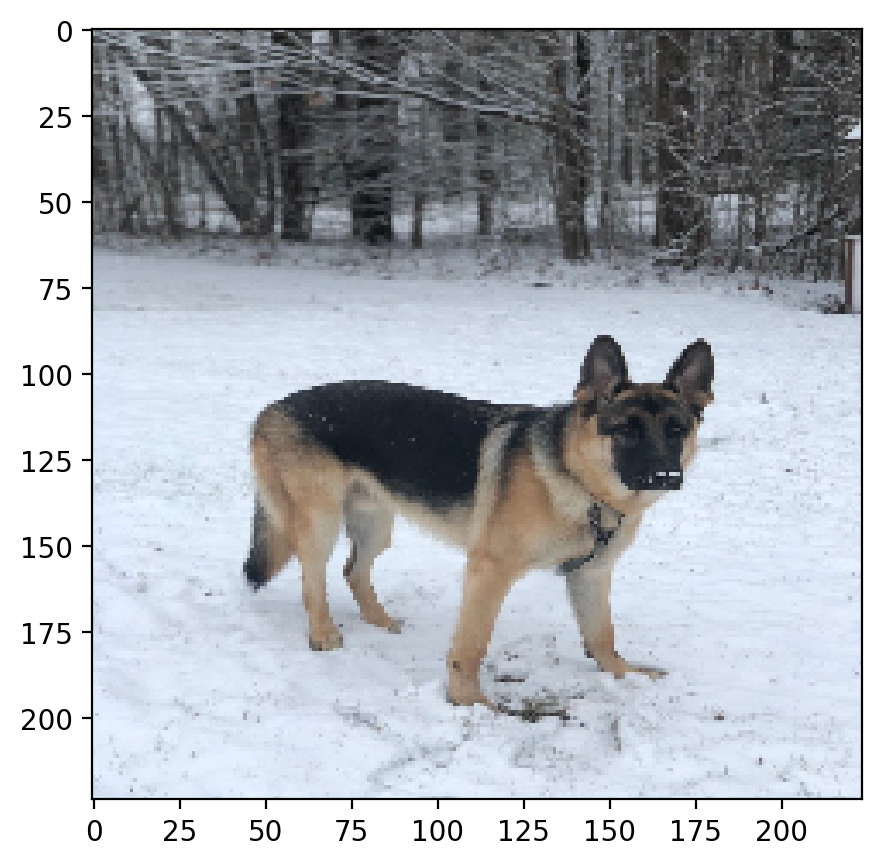

In [24]:
plt.figure(figsize=(5,5))
plt.imshow(image[0], cmap='gray')

In [41]:
yhat = model.predict(image)
label = decode_predictions(yhat)
label = label[0][0]
print('%s (%.2f%%)'%(label[1],label[2]*100))

2023-03-22 21:24:11.124857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


running_shoe (250.33%)


# Modeling

In [1]:
import numpy as np
import tensorflow.compat.v2 as tf

from keras import backend
from keras import layers
from keras import utils
from keras.applications import imagenet_utils
from keras.engine import sequential
from keras.engine import training as training_lib
from tensorflow.python.util.tf_export import keras_export

NotFoundError: dlopen(/opt/homebrew/anaconda3/lib/python3.9/site-packages/tensorflow-plugins/libmetal_plugin.dylib, 0x0006): symbol not found in flat namespace '__ZN10tensorflow8internal10LogMessage16VmoduleActivatedEPKci'

In [99]:
class StochasticDepth(layers.Layer):
    """
    Stochastic Depth layer (https://arxiv.org/abs/1603.09382)
    
    Args:
        drop_path_rate (float): Probability of dropping paths. Should be within [0, 1]
        
    Returns:
        Tensor either with the residual path dropped or kept
    """
    def __init__(self, drop_path_rate, **kwargs):
        super().__init__(**kwargs)
        self.drop_path_rate = drop_path_rate
        
    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_path_rate
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor) # Returns element-wise largest integer not greater than x
            return (x / keep_prob) * random_tensor
        return x
    
    def get_config(self):
        config = super().get_config()
        config.update(
            {"drop_path_rate": self.drop_path_rate}
        )

In [100]:
class LayerScale(layers.Layer):
    """
    LayerScale as introduced in CaiT: https://arxiv.org/abs/2103.17239
    
    Args:
      init_values (float): Initial value for layer scale. Should be within [0, 1]
      projection_dim (int): Projection dimensionality
      
    Returns:
      Tensor multiplied to the scale
    """
    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim
        
    def build(self, input_shape):
        self.gamma = tf.Variable(
            self.init_values * tf.ones((self.projection_dim,))
        )
        
    def call(self, x):
        return x * self.gamma
    
    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config

In [101]:
def PreStem(name=None):
    """
    Args:
      name (str): Name prefix
      
    Returns:
      A prestem function
    """
    if name is None:
        name = "prestem" + str(backend.get_uid("prestem"))
        
    def apply(x):
        x = layers.Normalization(
            mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
            variance=[
                (0.229 * 255) ** 2,
                (0.224 * 255) ** 2,
                (0.225 * 255) ** 2,
            ],
            name=name + "_prestem_normalization",
        )(x)
        return x

    return apply

In [102]:
def Head(num_classes=1000, name=None):
    """
    Args:
      num_classes: number of classes for Dense layer
      name: name prefix
      
    Returns:
      Classification head function
    """
    if name is None:
        name = str(backend.get_uid("head"))

    def apply(x):
        x = layers.GlobalAveragePooling2D(name=name + "_head_gap")(x)
        x = layers.LayerNormalization(
            epsilon=1e-6, name=name + "_head_layernorm"
        )(x)
        x = layers.Dense(num_classes, name=name + "_head_dense")(x)
        return x

    return apply

In [103]:
def ConvNeXtBlock(projection_dim, drop_path_rate=0.0, layer_scale_init_value=1e-6, name=None):
    """ 
    Args:
        projection_dim (int): Number of filters for convolution layers
        drop_path_rate (float): Probability of dropping paths. Should be within [0, 1]
        layer_scale_init_value (float) : Layer scale value. Should be a small float number
        name: name to path to the keras layer

    Returns:
        A function representing a ConvNeXtBlock block
    """
    if name is None:
        name = "prestem" + str(backend.get_uid(prefix="prestem"))
    
    def apply(inputs):
        x = inputs
        
        x = layers.Conv2D(
            filters=projection_dim, # 96 -> 192 -> 384 -> 768
            kernel_size=7,
            padding='same',
            groups=projection_dim, # 96 -> 192 -> 384 -> 768
            name=name + "_depthwise_conv"
        )(x)
        x = layers.LayerNormalization(epsilon=1e-6, name=name + "_layernorm")(x)
        x = layers.Dense(units=4 * projection_dim, name=name + "_pointwise_conv_1")(x) # 96 -> 192 -> 384 -> 768
        x = layers.Activation("gelu", name=name + "_gelu")(x)
        x = layers.Dense(units=projection_dim, name=name + "_pointwise_conv_2")(x) # 96 -> 192 -> 384 -> 768
        
        if layer_scale_init_value is not None:
            x = LayerScale(
                layer_scale_init_value,
                projection_dim,
                name=name + "_layer_scale",
            )(x)
        
        if drop_path_rate: # Regularization scheme
            layer = StochasticDepth(
                drop_path_rate, name=name + "_stochastic_depth"
            )
        else:
            layer = layers.Activation("linear", name=name + "_identity")
            
        return inputs + layer(x)
    
    return apply

In [104]:
def ConvNeXt(
    depths,
    projection_dims,
    drop_path_rate=0.0,
    layer_scale_init_value=1e-6,
    model_name="convnext",
    include_preprocessing=True,
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    """
    Args:
      depths: An iterable containing depths for each individual stages
      
      projection_dims: An iterable containing output number of channels of each individual stages
      
      drop_path_rate: Stochastic depth probability. If 0.0, then stochastic depth won't be used
      
      layer_scale_init_value: Layer scale coefficient. If 0.0, layer scaling won't be used.
      
      default_size: Default input image size.
      
      model_name: An optional name for the model.
      
      include_preprocessing: boolean denoting whther to include preprocessing in the model.
        When `weights="imagenet"` this should be always set to True.
        But for other models (e.g., randomly initialized) users should set it to False 
        and apply preprocessing to data accordingly.
      
      include_top: Boolean denoting whether to include classification head to the model.
      
      weights: one of `None` (random initialization), `"imagenet"` (pre-training on ImageNet-1k),
        or the path to the weights file to be loaded.
      
      input_tensor: optional Keras tensor (i.e. output of `layers.Input()`) to use as image input for the model.
      
      input_shape: optional shape tuple, only to be specified if `include_top` is False. 
        It should have exactly 3 inputs channels.
      
      pooling: optional pooling mode for feature extraction when `include_top` is `False`.
        - `None` means that the output of the model will be the 4D tensor output
          of the last convolutional layer.
        - `avg` means that global average pooling will be applied to the output
          of the last convolutional layer, and thus the output of the model will
          be a 2D tensor.
        - `max` means that global max pooling will be applied.
      
      classes: optional number of classes to classify images into, only to be specified if `include_top` is True,
        and if no `weights` argument is specified.
      
      classifier_activation: A `str` or callable. The activation function to use on the "top" layer.
        Ignored unless `include_top=True`.
        Set `classifier_activation=None` to return the logits of the "top" layer.
    
    Returns:
      A `keras.Model` instance.
    """
    inputs = layers.Input(shape=input_shape)
    x = inputs
    
    # Stem block
    stem = sequential.Sequential(
        [
            layers.Conv2D(
                projection_dims[0], # 96
                kernel_size=4,
                strides=4,
                name=model_name + "_stem_conv",
            ),
            layers.LayerNormalization(
                epsilon=1e-6, name=model_name + "_stem_layernorm",
            ),
        ],
        name=model_name + "_stem",
    )
    
    # Downsampling blocks
    downsample_layers = []
    downsample_layers.append(stem)
    
    num_downsample_layers = 3
    for i in range(num_downsample_layers):
        downsample_layer = sequential.Sequential(
            [
                layers.LayerNormalization(
                    epsilon=1e-6, name=model_name + "_downsampling_layernorm_" + str(i),
                ),
                layers.Conv2D(
                    projection_dims[i+1],
                    kernel_size=2,
                    strides=2,
                    name=model_name + "_downsampling_conv_" + str(i),
                ),
            ],
            name=model_name + "_downsampling_block_" + str(i),
        )
        downsample_layers.append(downsample_layer)
        
    depth_drop_rates = [
        float(x) for x in np.linspace(0.0, drop_path_rate, sum(depths))
    ]

    # First apply downsampling blocks and then apply ConvNeXt stages
    cur = 0

    num_convnext_blocks = 4
    for i in range(num_convnext_blocks):
        x = downsample_layers[i](x)
        for j in range(depths[i]):
            x = ConvNeXtBlock(
                projection_dim=projection_dims[i],
                drop_path_rate=depth_drop_rates[cur + j],
                layer_scale_init_value=layer_scale_init_value,
                name=model_name + f"_stage_{i}_block_{j}",
            )(x)
        cur += depths[i]

    if include_top:
        x = Head(num_classes=classes, name=model_name)(x)

    else:
        if pooling == "avg":
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == "max":
            x = layers.GlobalMaxPooling2D()(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)

    model = training_lib.Model(inputs=inputs, outputs=x, name=model_name)
    
    return model

In [105]:
model_convnext_t = ConvNeXt(
                            depths=[3, 3, 9, 3],
                            projection_dims=[96, 192, 384, 768],
                            drop_path_rate=0.0,
                            layer_scale_init_value=1e-6,
                            model_name="convnext_tiny",
                            include_top=True,
                            include_preprocessing=False,
                            weights=None, #"imagenet"
                            input_tensor=None,
                            input_shape=(224,224,3),
                            pooling=None,
                            classes=1000,
                            classifier_activation="softmax",
                           )

In [106]:
model_convnext_t.summary(expand_nested=True)

Model: "convnext_tiny"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 convnext_tiny_stem (Sequential  (None, 56, 56, 96)  4896        ['input_14[0][0]']               
 )                                                                                                
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| convnext_tiny_stem_conv (Conv2  (None, 56, 56, 96)  4704      []                               |
| D)                                                                                  

 convnext_tiny_stage_0_block_2_  (None, 56, 56, 96)  0           ['convnext_tiny_stage_0_block_2_l
 identity (Activation)                                           ayer_scale[0][0]']               
                                                                                                  
 tf.__operators__.add_164 (TFOp  (None, 56, 56, 96)  0           ['tf.__operators__.add_163[0][0]'
 Lambda)                                                         , 'convnext_tiny_stage_0_block_2_
                                                                 identity[0][0]']                 
                                                                                                  
 convnext_tiny_downsampling_blo  (None, 28, 28, 192)  74112      ['tf.__operators__.add_164[0][0]'
 ck_0 (Sequential)                                               ]                                
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| convnext

 layer_scale (LayerScale)                                        ointwise_conv_2[0][0]']          
                                                                                                  
 convnext_tiny_stage_1_block_2_  (None, 28, 28, 192)  0          ['convnext_tiny_stage_1_block_2_l
 identity (Activation)                                           ayer_scale[0][0]']               
                                                                                                  
 tf.__operators__.add_167 (TFOp  (None, 28, 28, 192)  0          ['tf.__operators__.add_166[0][0]'
 Lambda)                                                         , 'convnext_tiny_stage_1_block_2_
                                                                 identity[0][0]']                 
                                                                                                  
 convnext_tiny_downsampling_blo  (None, 14, 14, 384)  295680     ['tf.__operators__.add_167[0][0]'
 ck_1 (Seq

                                                                                                  
 convnext_tiny_stage_2_block_2_  (None, 14, 14, 384)  384        ['convnext_tiny_stage_2_block_2_p
 layer_scale (LayerScale)                                        ointwise_conv_2[0][0]']          
                                                                                                  
 convnext_tiny_stage_2_block_2_  (None, 14, 14, 384)  0          ['convnext_tiny_stage_2_block_2_l
 identity (Activation)                                           ayer_scale[0][0]']               
                                                                                                  
 tf.__operators__.add_170 (TFOp  (None, 14, 14, 384)  0          ['tf.__operators__.add_169[0][0]'
 Lambda)                                                         , 'convnext_tiny_stage_2_block_2_
                                                                 identity[0][0]']                 
          

 Lambda)                                                         , 'convnext_tiny_stage_2_block_5_
                                                                 identity[0][0]']                 
                                                                                                  
 convnext_tiny_stage_2_block_6_  (None, 14, 14, 384)  19200      ['tf.__operators__.add_173[0][0]'
 depthwise_conv (Conv2D)                                         ]                                
                                                                                                  
 convnext_tiny_stage_2_block_6_  (None, 14, 14, 384)  768        ['convnext_tiny_stage_2_block_6_d
 layernorm (LayerNormalization)                                  epthwise_conv[0][0]']            
                                                                                                  
 convnext_tiny_stage_2_block_6_  (None, 14, 14, 1536  591360     ['convnext_tiny_stage_2_block_6_l
 pointwise

|                                                                                                |
| convnext_tiny_downsampling_con  (None, 7, 7, 768)  1180416    []                               |
| v_2 (Conv2D)                                                                                   |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 convnext_tiny_stage_3_block_0_  (None, 7, 7, 768)   38400       ['convnext_tiny_downsampling_bloc
 depthwise_conv (Conv2D)                                         k_2[0][0]']                      
                                                                                                  
 convnext_tiny_stage_3_block_0_  (None, 7, 7, 768)   1536        ['convnext_tiny_stage_3_block_0_d
 layernorm (LayerNormalization)                                  epthwise_conv[0][0]']            
                                                                                                  
 convnext_

 convnext_tiny_head_layernorm (  (None, 768)         1536        ['convnext_tiny_head_gap[0][0]'] 
 LayerNormalization)                                                                              
                                                                                                  
 convnext_tiny_head_dense (Dens  (None, 1000)        769000      ['convnext_tiny_head_layernorm[0]
 e)                                                              [0]']                            
                                                                                                  
Total params: 28,589,128
Trainable params: 28,589,128
Non-trainable params: 0
__________________________________________________________________________________________________


# MNIST

In [107]:
from tensorflow import keras
import tensorflow as tf
from keras.datasets import cifar10, mnist
import numpy as np

(x_train, y_train),(x_test, y_test) = mnist.load_data()

unique, counts = np.unique(y_train, return_counts=True)
print(f"Train Labels: {dict(zip(unique, counts))}")

unique, counts = np.unique(y_test, return_counts=True)
print(f"Test Labels: {dict(zip(unique, counts))}")

print(x_train.shape)

Train Labels: {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
Test Labels: {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}
(60000, 28, 28)


In [108]:
x_train = tf.pad(x_train, [[0,0], [2,2], [2,2]])/255
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_train = tf.repeat(x_train, 3, axis=3)

x_test = tf.pad(x_test, [[0,0], [2,2], [2,2]])/255
x_test = tf.expand_dims(x_test, axis=3, name=None)
x_test = tf.repeat(x_test, 3, axis=3)

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)


x_val = x_train[-2000:, :, :, :]
y_val = y_train[-2000:]
x_train = x_train[:-2000, :, :, :]
y_train = y_train[:-2000]

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)

(58000, 32, 32, 3)
(2000, 32, 32, 3)
(58000, 10)


In [110]:
!pip install keras==2.11.0 --user

In [92]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.e,
              metrics=['accuracy']
             )

hist = model.fit(x_train, y_train, batch_size=256, epochs=5,
                 validation_data=(x_val, y_val), verbose=2,
                 shuffle=True
                )

ModuleNotFoundError: No module named 'keras.optimizers.optimizer_experimental'; 'keras.optimizers' is not a package